In [1]:
%matplotlib notebook
import numpy as np
import h5py
from numpy.fft import fftshift
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt

# This imports all necessary operators. GPU will be auto-selected
from pynx.cdi import *
from pynx.utils.math import smaller_primes

import glob

# Which matplotlib to use
* %inline, plots do not update
* %notebook on jupyter notebook
* %ipyml on jupyter lab, not supported yet

# Filename

In [2]:
glob.glob("*.npz")

['S290_pynx_align-q-y_norm_120_360_300_1_1_1.npz',
 'S290_data_before_masking_stack.npz',
 'S290_maskpynx_align-q-y_norm_120_360_300_1_1_1.npz']

# Extract data

In [4]:
nrj = 12996
wavelength = 12.384 / nrj * 1e-10
print("  CXI input: Energy = %8.2fkeV" % nrj)

detector_distance = 0.83
print("  CXI input: detector distance = %8.2fm" % detector_distance)

pixel_size_detector = 55e-6
print("  CXI input: detector pixel size = %8.2fum" % (pixel_size_detector * 1e6))

iobs = np.load(glob.glob("*_pynx_align*.npz")[0])["data"]
# detector mask
mask = np.load(glob.glob("*maskpynx*.npz")[0])["mask"].astype(np.int8)
nb = mask.sum()
print("  CXI input: loading mask, with %d pixels masked (%6.3f%%)" % (nb, nb * 100 / mask.size))

  CXI input: Energy = 12.996.00keV
  CXI input: detector distance =     0.83m
  CXI input: detector pixel size =    55.00um
  CXI input: loading mask, with 470880 pixels masked ( 3.633%)


# Centre & crop data

crop data around center of mass, with a maximum size along the 3 directions

In [5]:
max_size = 256
if iobs.ndim == 3:
    nz0, ny0, nx0 = iobs.shape
    # Find center of mass
    z0, y0, x0 = center_of_mass(iobs)
    print("Center of mass at:", z0, y0, x0)
    iz0, iy0, ix0 = int(round(z0)), int(round(y0)), int(round(x0))
    # Max symmetrical box around center of mass
    nx = 2 * min(ix0, nx0 - ix0)
    ny = 2 * min(iy0, ny0 - iy0)
    nz = 2 * min(iz0, nz0 - iz0)
    if max_size is not None:
        nx = min(nx, max_size)
        ny = min(ny, max_size)
        nz = min(nz, max_size)
    # Crop data to fulfill FFT size requirements
    nz1, ny1, nx1 = smaller_primes((nz, ny, nx), maxprime=7, required_dividers=(2,))

    print("Centering & reshaping data: (%d, %d, %d) -> (%d, %d, %d)" % (nz0, ny0, nx0, nz1, ny1, nx1))
    iobs = iobs[iz0 - nz1 // 2:iz0 + nz1 // 2, iy0 - ny1 // 2:iy0 + ny1 // 2,
                ix0 - nx1 // 2:ix0 + nx1 // 2]
    if mask is not None:
        mask = mask[iz0 - nz1 // 2:iz0 + nz1 // 2, iy0 - ny1 // 2:iy0 + ny1 // 2,
                    ix0 - nx1 // 2:ix0 + nx1 // 2]
        print("Centering & reshaping mask: (%d, %d, %d) -> (%d, %d, %d)" % (nz0, ny0, nx0, nz1, ny1, nx1))
else:
    ny0, nx0 = iobs.shape
    # Find center of mass
    y0, x0 = center_of_mass(iobs)
    print("Center of mass at:", y0, x0)
    iy0, ix0 = int(round(y0)), int(round(x0))
    # Max symmetrical box around center of mass
    nx = 2 * min(ix0, nx0 - ix0)
    ny = 2 * min(iy0, ny0 - iy0)
    if max_size is not None:
        nx = min(nx, max_size)
        ny = min(ny, max_size)
        nz = min(nz, max_size)
    # Crop data to fulfill FFT size requirements
    ny1, nx1 = smaller_primes((ny, nx), maxprime=7, required_dividers=(2,))

    print("Centering & reshaping data: (%d, %d) -> (%d, %d)" % (ny0, nx0, ny1, nx1))
    iobs = iobs[iy0 - ny1 // 2:iy0 + ny1 // 2, ix0 - nx1 // 2:ix0 + nx1 // 2]
    if mask is not None:
        mask = mask[iy0 - ny1 // 2:iy0 + ny1 // 2, ix0 - nx1 // 2:ix0 + nx1 // 2]

Center of mass at: 59.602063512324165 178.62211095918107 150.3382691306778
Centering & reshaping data: (120, 360, 300) -> (120, 256, 256)
Centering & reshaping mask: (120, 360, 300) -> (120, 256, 256)


# Run 1

Run 0
Threshold: 0.16141015963830357
AutoCorrelation: 63083 pixels in support (  0.80%), threshold = 2715983.000000


<IPython.core.display.Javascript object>


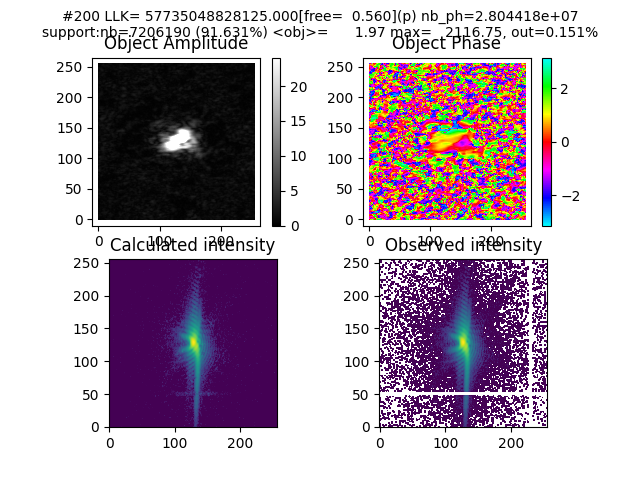

 HIO #  0 LLK=   6.472[free=  5.403](p), nb photons=1.164842e+07, support:nb= 63083 ( 0.802%) <obj>=     13.59 max=   1024.04, out=33.813% dt/cycle=7.0638s 
 HIO # 50 LLK=   6.997[free=  0.741](p), nb photons=4.996753e+07, support:nb=447633 ( 5.692%) <obj>=     10.57 max=   1106.92, out=18.173% dt/cycle=0.0165s 
 HIO #100 LLK=   5.334[free=  0.473](p), nb photons=3.914778e+07, support:nb=2420746 (30.781%) <obj>=      4.02 max=   1562.71, out=5.406% dt/cycle=0.0159s 
 HIO #150 LLK= 75795445000000000.000[free=  0.498](p), nb photons=3.145645e+07, support:nb=7713053 (98.077%) <obj>=      2.02 max=   2131.25, out=0.067% dt/cycle=0.0160s 
 HIO #200 LLK= 57735048828125.000[free=  0.560](p), nb photons=2.804418e+07, support:nb=7206190 (91.631%) <obj>=      1.97 max=   2116.75, out=0.151% dt/cycle=0.0171s 

##################################################################################################

Run 1
Threshold: 0.19651991252166645
AutoCorrelation: 62003 pixels in support (  0.79%), 

<IPython.core.display.Javascript object>


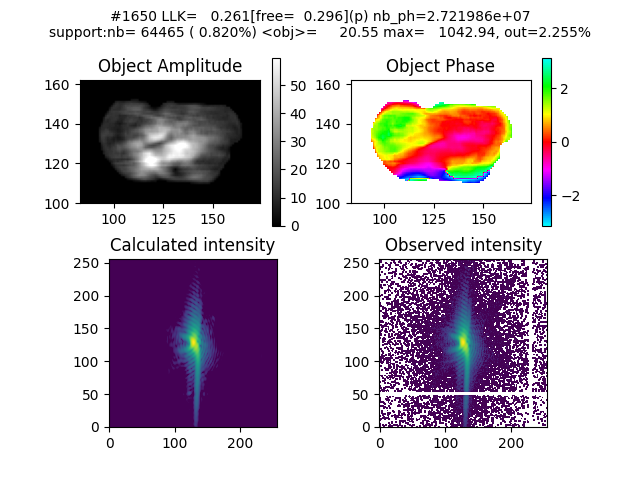

 HIO #  0 LLK=   6.760[free=  1.372](p), nb photons=1.177284e+07, support:nb= 62003 ( 0.788%) <obj>=     13.78 max=   1020.83, out=34.365% dt/cycle=0.6586s 
 HIO # 50 LLK=   6.852[free=  0.572](p), nb photons=4.948651e+07, support:nb=280938 ( 3.572%) <obj>=     13.27 max=   1053.84, out=21.268% dt/cycle=0.0178s 
 HIO #100 LLK=   4.994[free=  0.437](p), nb photons=4.139127e+07, support:nb=1180164 (15.007%) <obj>=      5.92 max=   1353.79, out=7.614% dt/cycle=0.0157s 
 HIO #150 LLK=   3.555[free=  0.404](p), nb photons=3.397738e+07, support:nb=3226751 (41.030%) <obj>=      3.24 max=   1676.50, out=3.802% dt/cycle=0.0159s 
 HIO #200 LLK= 60497335000000000.000[free=  0.468](p), nb photons=3.149459e+07, support:nb=7605951 (96.715%) <obj>=      2.03 max=   2090.11, out=0.148% dt/cycle=0.0169s 
 HIO #250 LLK=   0.004[free=  0.596](p), nb photons=2.809847e+07, support:nb=3572641 (45.428%) <obj>=      2.80 max=   1827.00, out=1.553% dt/cycle=0.0161s 
 HIO #300 LLK= 41001825000000000.000[free=  

<IPython.core.display.Javascript object>


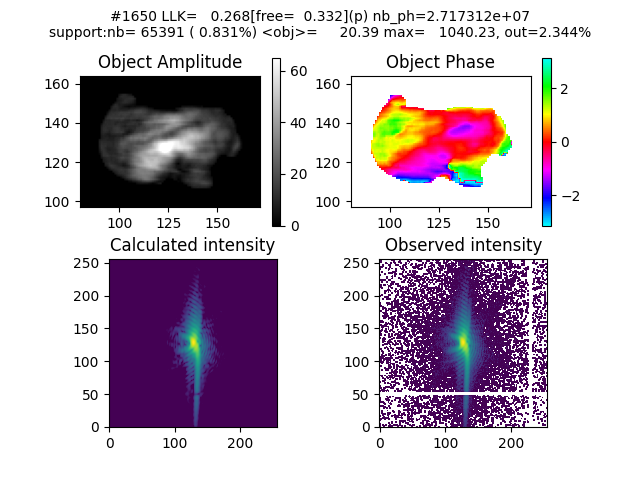

 HIO #  0 LLK=   6.771[free=  5.787](p), nb photons=1.153217e+07, support:nb= 64191 ( 0.816%) <obj>=     13.40 max=   1024.59, out=34.481% dt/cycle=0.7079s 
 HIO # 50 LLK=   6.656[free=  0.695](p), nb photons=4.864977e+07, support:nb=331194 ( 4.211%) <obj>=     12.12 max=   1093.16, out=20.964% dt/cycle=0.0158s 
 HIO #100 LLK=   4.999[free=  0.483](p), nb photons=4.087993e+07, support:nb=1472214 (18.720%) <obj>=      5.27 max=   1389.17, out=7.096% dt/cycle=0.0170s 
 HIO #150 LLK=   4.796[free=  0.419](p), nb photons=3.295536e+07, support:nb=4679066 (59.497%) <obj>=      2.65 max=   1863.86, out=2.189% dt/cycle=0.0162s 
 HIO #200 LLK= 30924095000000000.000[free=  0.676](p), nb photons=3.052232e+07, support:nb=7861134 (99.959%) <obj>=      1.97 max=   2130.79, out=0.002% dt/cycle=0.0163s 
 HIO #250 LLK=   0.000[free=  0.677](p), nb photons=2.818191e+07, support:nb=4503681 (57.267%) <obj>=      2.50 max=   1952.89, out=0.745% dt/cycle=0.0162s 
 HIO #300 LLK= 24945810000000000.000[free=  

<IPython.core.display.Javascript object>


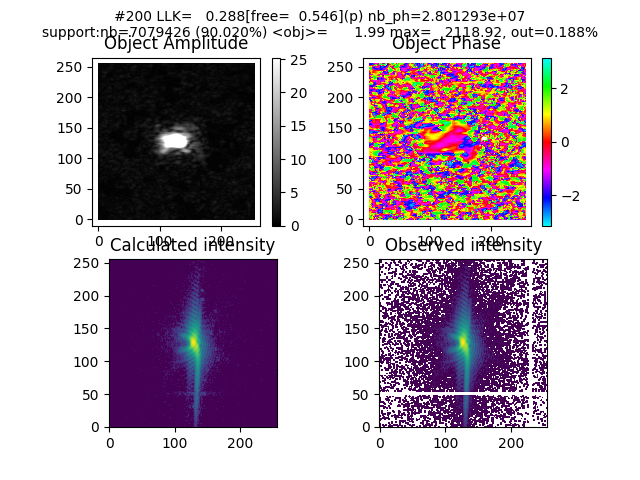

 HIO #  0 LLK=   6.576[free=  5.329](p), nb photons=1.169400e+07, support:nb= 62781 ( 0.798%) <obj>=     13.65 max=   1022.69, out=33.846% dt/cycle=0.7019s 
 HIO # 50 LLK=   7.198[free=  0.770](p), nb photons=4.970500e+07, support:nb=461475 ( 5.868%) <obj>=     10.38 max=   1127.52, out=21.072% dt/cycle=0.0171s 
 HIO #100 LLK=   5.347[free=  0.419](p), nb photons=3.933458e+07, support:nb=2398237 (30.495%) <obj>=      4.05 max=   1561.88, out=5.429% dt/cycle=0.0160s 
 HIO #150 LLK= 79690345000000000.000[free=  0.469](p), nb photons=3.158750e+07, support:nb=7683052 (97.695%) <obj>=      2.03 max=   2136.95, out=0.082% dt/cycle=0.0162s 
 HIO #200 LLK=   0.288[free=  0.546](p), nb photons=2.801293e+07, support:nb=7079426 (90.020%) <obj>=      1.99 max=   2118.92, out=0.188% dt/cycle=0.0164s 

##################################################################################################

Run 4
Threshold: 0.15940186993408306
AutoCorrelation: 62753 pixels in support (  0.80%), threshold =

<IPython.core.display.Javascript object>


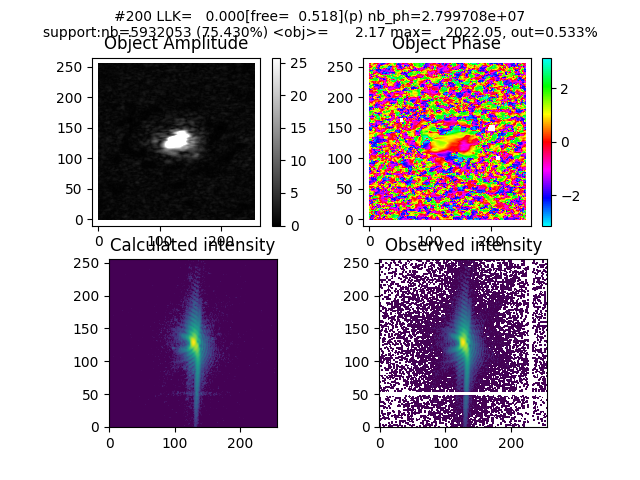

 HIO #  0 LLK=   6.696[free=  4.623](p), nb photons=1.169325e+07, support:nb= 62753 ( 0.798%) <obj>=     13.65 max=   1021.57, out=34.194% dt/cycle=0.7425s 
 HIO # 50 LLK=   7.254[free=  0.746](p), nb photons=4.878944e+07, support:nb=506985 ( 6.447%) <obj>=      9.81 max=   1124.47, out=22.403% dt/cycle=0.0159s 
 HIO #100 LLK=   5.869[free=  0.456](p), nb photons=3.925341e+07, support:nb=2826018 (35.935%) <obj>=      3.73 max=   1622.53, out=4.892% dt/cycle=0.0160s 
 HIO #150 LLK= 62088400000000000.000[free=  0.516](p), nb photons=3.103884e+07, support:nb=7855106 (99.883%) <obj>=      1.99 max=   2135.33, out=0.003% dt/cycle=0.0162s 
 HIO #200 LLK=   0.000[free=  0.518](p), nb photons=2.799708e+07, support:nb=5932053 (75.430%) <obj>=      2.17 max=   2022.05, out=0.533% dt/cycle=0.0163s 

##################################################################################################

Run 5
Threshold: 0.19481776411426246
AutoCorrelation: 62793 pixels in support (  0.80%), threshold =

<IPython.core.display.Javascript object>


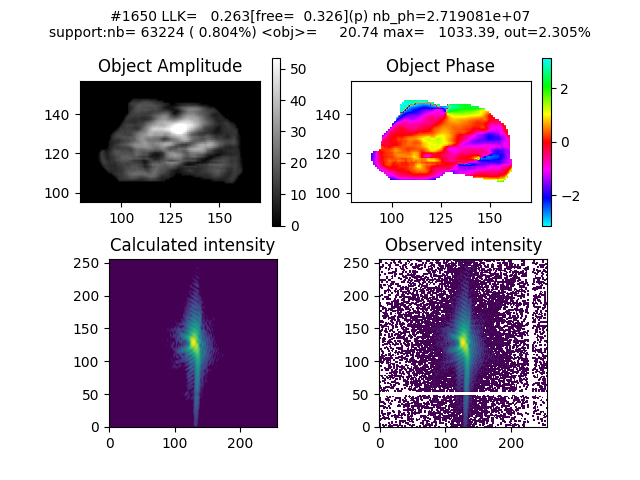

 HIO #  0 LLK=   6.685[free=  4.336](p), nb photons=1.167567e+07, support:nb= 62793 ( 0.798%) <obj>=     13.64 max=   1021.39, out=34.167% dt/cycle=0.6730s 
 HIO # 50 LLK=   7.264[free=  1.469](p), nb photons=5.078968e+07, support:nb=324614 ( 4.128%) <obj>=     12.51 max=   1061.05, out=21.412% dt/cycle=0.0159s 
 HIO #100 LLK=   4.929[free=  0.479](p), nb photons=4.096112e+07, support:nb=1303574 (16.576%) <obj>=      5.61 max=   1368.49, out=7.239% dt/cycle=0.0158s 
 HIO #150 LLK=   3.944[free=  0.419](p), nb photons=3.370038e+07, support:nb=3787285 (48.158%) <obj>=      2.98 max=   1761.63, out=3.135% dt/cycle=0.0160s 
 HIO #200 LLK= 42946650000000000.000[free=  0.576](p), nb photons=3.084680e+07, support:nb=7802336 (99.212%) <obj>=      1.99 max=   2101.38, out=0.043% dt/cycle=0.0173s 
 HIO #250 LLK=   0.000[free=  0.605](p), nb photons=2.808422e+07, support:nb=3745313 (47.624%) <obj>=      2.74 max=   1857.07, out=1.149% dt/cycle=0.0159s 
 HIO #300 LLK= 35267440000000000.000[free=  

<IPython.core.display.Javascript object>


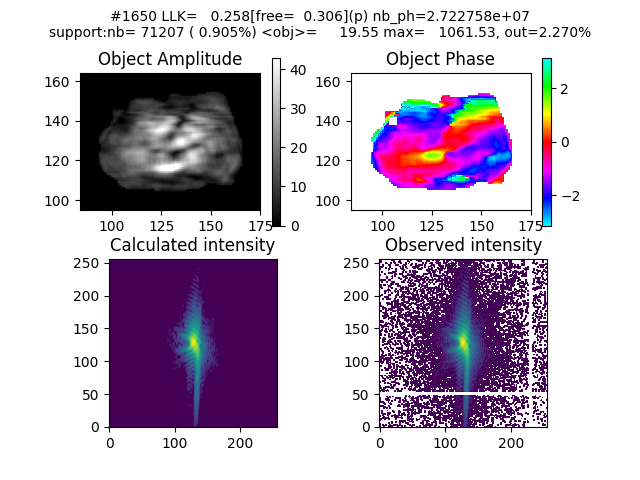

 HIO #  0 LLK=   6.776[free=  2.587](p), nb photons=1.175167e+07, support:nb= 62187 ( 0.791%) <obj>=     13.75 max=   1020.65, out=34.291% dt/cycle=0.7192s 
 HIO # 50 LLK=   6.749[free=  0.568](p), nb photons=4.877937e+07, support:nb=318241 ( 4.047%) <obj>=     12.38 max=   1086.38, out=21.584% dt/cycle=0.0159s 
 HIO #100 LLK=   5.175[free=  0.463](p), nb photons=4.131225e+07, support:nb=1480682 (18.828%) <obj>=      5.28 max=   1385.26, out=6.901% dt/cycle=0.0172s 
 HIO #150 LLK=   6.337[free=  0.396](p), nb photons=3.322871e+07, support:nb=5183369 (65.910%) <obj>=      2.53 max=   1913.88, out=1.806% dt/cycle=0.0160s 
 HIO #200 LLK= 26155235000000000.000[free=  0.729](p), nb photons=3.033908e+07, support:nb=7863731 (99.993%) <obj>=      1.96 max=   2147.86, out=0.000% dt/cycle=0.0160s 
 HIO #250 LLK=   0.000[free=  0.729](p), nb photons=2.823290e+07, support:nb=4948526 (62.924%) <obj>=      2.39 max=   2002.46, out=0.598% dt/cycle=0.0159s 
 HIO #300 LLK= 21481475000000000.000[free=  

<IPython.core.display.Javascript object>


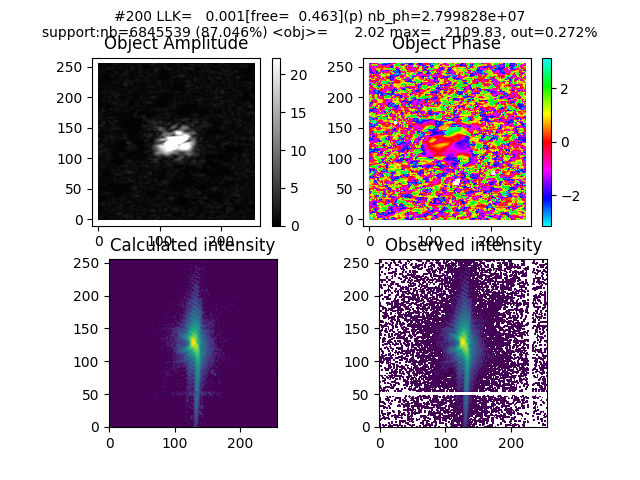

 HIO #  0 LLK=   6.638[free=  2.311](p), nb photons=1.175241e+07, support:nb= 62147 ( 0.790%) <obj>=     13.75 max=   1021.83, out=34.131% dt/cycle=0.6770s 
 HIO # 50 LLK=   7.560[free=  0.614](p), nb photons=5.112287e+07, support:nb=501562 ( 6.378%) <obj>=     10.10 max=   1136.71, out=22.391% dt/cycle=0.0174s 
 HIO #100 LLK=   5.206[free=  0.425](p), nb photons=3.835266e+07, support:nb=2608650 (33.171%) <obj>=      3.83 max=   1594.94, out=4.905% dt/cycle=0.0161s 
 HIO #150 LLK= 71809890000000000.000[free=  0.453](p), nb photons=3.136735e+07, support:nb=7834117 (99.616%) <obj>=      2.00 max=   2163.74, out=0.012% dt/cycle=0.0158s 
 HIO #200 LLK=   0.001[free=  0.463](p), nb photons=2.799828e+07, support:nb=6845539 (87.046%) <obj>=      2.02 max=   2109.83, out=0.272% dt/cycle=0.0159s 

##################################################################################################

Run 8
Threshold: 0.19136698990390388
AutoCorrelation: 62505 pixels in support (  0.79%), threshold =

<IPython.core.display.Javascript object>


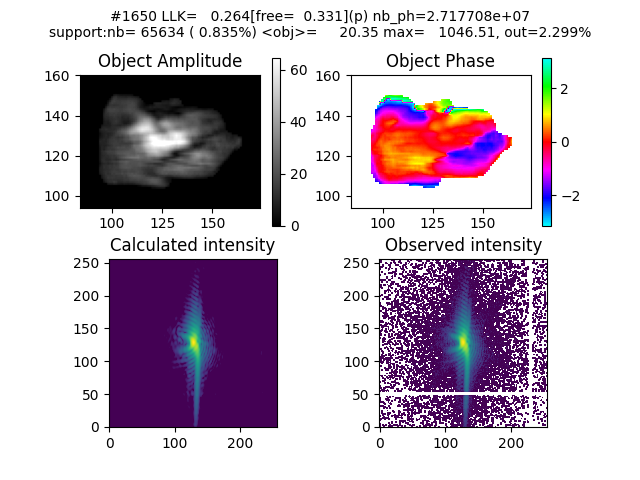

 HIO #  0 LLK=   6.696[free=  3.286](p), nb photons=1.171721e+07, support:nb= 62505 ( 0.795%) <obj>=     13.69 max=   1021.22, out=34.135% dt/cycle=0.6658s 
 HIO # 50 LLK=   7.279[free=  0.679](p), nb photons=5.169784e+07, support:nb=333813 ( 4.245%) <obj>=     12.44 max=   1074.12, out=19.922% dt/cycle=0.0159s 
 HIO #100 LLK=   5.108[free=  0.504](p), nb photons=4.132474e+07, support:nb=1445317 (18.378%) <obj>=      5.35 max=   1413.86, out=6.750% dt/cycle=0.0158s 
 HIO #150 LLK=   4.251[free=  0.426](p), nb photons=3.309611e+07, support:nb=4281813 (54.446%) <obj>=      2.78 max=   1813.56, out=2.583% dt/cycle=0.0161s 
 HIO #200 LLK= 36694192500000000.000[free=  0.613](p), nb photons=3.073300e+07, support:nb=7852549 (99.850%) <obj>=      1.98 max=   2117.36, out=0.007% dt/cycle=0.0178s 
 HIO #250 LLK=   0.000[free=  0.617](p), nb photons=2.811449e+07, support:nb=4174735 (53.085%) <obj>=      2.60 max=   1910.65, out=0.895% dt/cycle=0.0161s 
 HIO #300 LLK= 29838117500000000.000[free=  

<IPython.core.display.Javascript object>


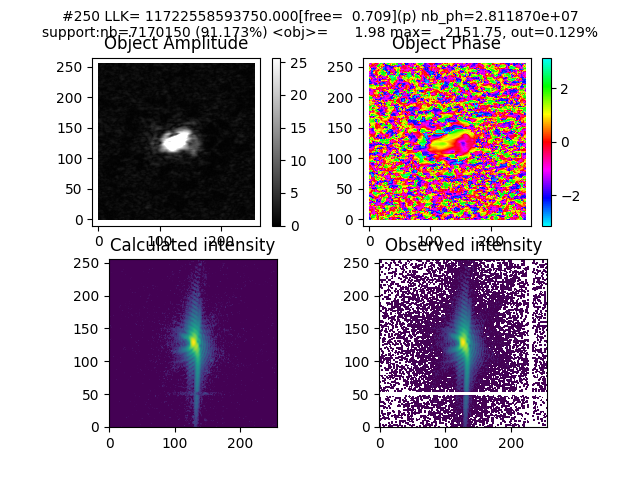

 HIO #  0 LLK=   6.756[free=  2.145](p), nb photons=1.175561e+07, support:nb= 62171 ( 0.791%) <obj>=     13.75 max=   1020.65, out=34.272% dt/cycle=0.6299s 
 HIO # 50 LLK=   7.191[free=  0.802](p), nb photons=4.877556e+07, support:nb=458634 ( 5.832%) <obj>=     10.31 max=   1125.88, out=24.442% dt/cycle=0.0152s 
 HIO #100 LLK=   5.164[free=  0.417](p), nb photons=3.935793e+07, support:nb=2214233 (28.155%) <obj>=      4.22 max=   1532.36, out=5.595% dt/cycle=0.0153s 
 HIO #150 LLK= 86264060000000000.000[free=  0.426](p), nb photons=3.181459e+07, support:nb=7501183 (95.382%) <obj>=      2.06 max=   2124.31, out=0.178% dt/cycle=0.0170s 
 HIO #200 LLK= 516498593750000.000[free=  0.707](p), nb photons=2.816532e+07, support:nb=7774568 (98.859%) <obj>=      1.90 max=   2174.64, out=0.013% dt/cycle=0.0157s 
 HIO #250 LLK= 11722558593750.000[free=  0.709](p), nb photons=2.811870e+07, support:nb=7170150 (91.173%) <obj>=      1.98 max=   2151.75, out=0.129% dt/cycle=0.0169s 

####################

<IPython.core.display.Javascript object>


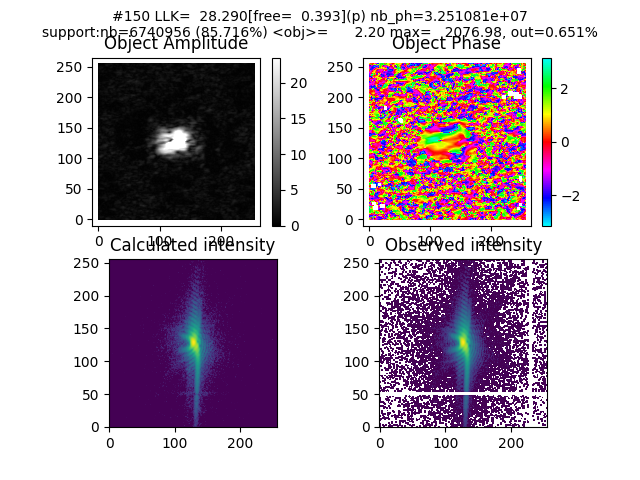

 HIO #  0 LLK=   6.764[free=  1.537](p), nb photons=1.177295e+07, support:nb= 62035 ( 0.789%) <obj>=     13.78 max=   1020.93, out=34.295% dt/cycle=0.6748s 
 HIO # 50 LLK=   6.972[free=  0.582](p), nb photons=4.865250e+07, support:nb=402893 ( 5.123%) <obj>=     10.99 max=   1128.71, out=23.830% dt/cycle=0.0176s 
 HIO #100 LLK=   4.980[free=  0.420](p), nb photons=3.973412e+07, support:nb=1842894 (23.434%) <obj>=      4.64 max=   1476.58, out=6.374% dt/cycle=0.0161s 
 HIO #150 LLK=  28.290[free=  0.393](p), nb photons=3.251081e+07, support:nb=6740956 (85.716%) <obj>=      2.20 max=   2076.98, out=0.651% dt/cycle=0.0161s 

##################################################################################################

Run 11
Threshold: 0.15723399672344043
AutoCorrelation: 62035 pixels in support (  0.79%), threshold = 2761271.250000


<IPython.core.display.Javascript object>


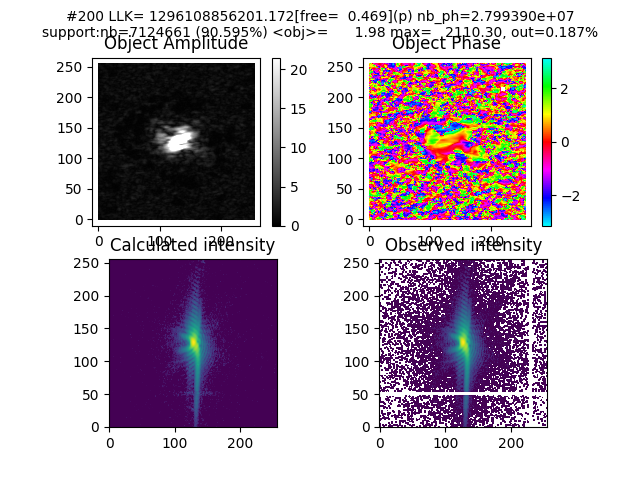

 HIO #  0 LLK=   6.778[free=  1.503](p), nb photons=1.176891e+07, support:nb= 62035 ( 0.789%) <obj>=     13.77 max=   1020.95, out=34.356% dt/cycle=0.6656s 
 HIO # 50 LLK=   6.961[free=  0.517](p), nb photons=4.847920e+07, support:nb=475859 ( 6.051%) <obj>=     10.09 max=   1138.72, out=22.139% dt/cycle=0.0176s 
 HIO #100 LLK=   5.393[free=  0.435](p), nb photons=3.880994e+07, support:nb=2607589 (33.157%) <obj>=      3.86 max=   1587.89, out=5.116% dt/cycle=0.0160s 
 HIO #150 LLK= 70732725000000000.000[free=  0.461](p), nb photons=3.131284e+07, support:nb=7841088 (99.705%) <obj>=      2.00 max=   2148.34, out=0.009% dt/cycle=0.0161s 
 HIO #200 LLK= 1296108856201.172[free=  0.469](p), nb photons=2.799390e+07, support:nb=7124661 (90.595%) <obj>=      1.98 max=   2110.30, out=0.187% dt/cycle=0.0162s 

##################################################################################################

Run 12
Threshold: 0.15088957824006416
AutoCorrelation: 62171 pixels in support (  0.79%), 

<IPython.core.display.Javascript object>


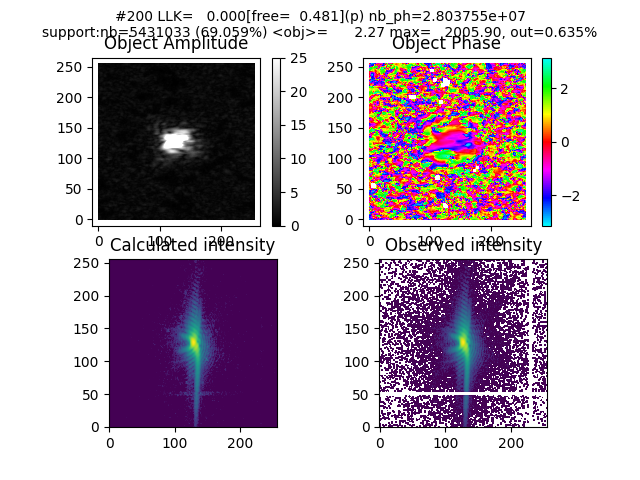

 HIO #  0 LLK=   6.758[free=  1.891](p), nb photons=1.175667e+07, support:nb= 62171 ( 0.791%) <obj>=     13.75 max=   1021.52, out=34.249% dt/cycle=0.7584s 
 HIO # 50 LLK=   6.954[free=  0.589](p), nb photons=4.861758e+07, support:nb=519091 ( 6.601%) <obj>=      9.68 max=   1147.75, out=21.300% dt/cycle=0.0160s 
 HIO #100 LLK=   5.974[free=  0.393](p), nb photons=3.854664e+07, support:nb=3126610 (39.757%) <obj>=      3.51 max=   1667.02, out=4.539% dt/cycle=0.0161s 
 HIO #150 LLK= 55229620000000000.000[free=  0.481](p), nb photons=3.092533e+07, support:nb=7864284 (100.000%) <obj>=      1.98 max=   2146.42, out=0.000% dt/cycle=0.0162s 
 HIO #200 LLK=   0.000[free=  0.481](p), nb photons=2.803755e+07, support:nb=5431033 (69.059%) <obj>=      2.27 max=   2005.90, out=0.635% dt/cycle=0.0165s 

##################################################################################################

Run 13
Threshold: 0.19315047859457035
AutoCorrelation: 62755 pixels in support (  0.80%), threshold

<IPython.core.display.Javascript object>


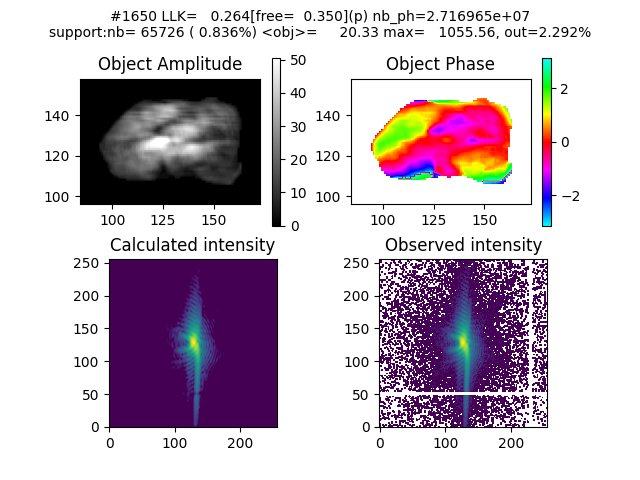

 HIO #  0 LLK=   6.576[free=  5.005](p), nb photons=1.168985e+07, support:nb= 62755 ( 0.798%) <obj>=     13.65 max=   1021.06, out=34.052% dt/cycle=0.6687s 
 HIO # 50 LLK=   6.932[free=  0.698](p), nb photons=5.061226e+07, support:nb=304303 ( 3.869%) <obj>=     12.90 max=   1077.24, out=19.585% dt/cycle=0.0159s 
 HIO #100 LLK=   4.941[free=  0.473](p), nb photons=4.111793e+07, support:nb=1260939 (16.034%) <obj>=      5.71 max=   1374.65, out=7.273% dt/cycle=0.0158s 
 HIO #150 LLK=   3.765[free=  0.427](p), nb photons=3.364970e+07, support:nb=3609891 (45.902%) <obj>=      3.05 max=   1752.93, out=3.333% dt/cycle=0.0162s 
 HIO #200 LLK= 45369460000000000.000[free=  0.545](p), nb photons=3.087156e+07, support:nb=7770461 (98.807%) <obj>=      1.99 max=   2111.39, out=0.061% dt/cycle=0.0183s 
 HIO #250 LLK=   0.000[free=  0.586](p), nb photons=2.805734e+07, support:nb=3677735 (46.765%) <obj>=      2.76 max=   1861.74, out=1.230% dt/cycle=0.0163s 
 HIO #300 LLK= 35802395000000000.000[free=  

<IPython.core.display.Javascript object>


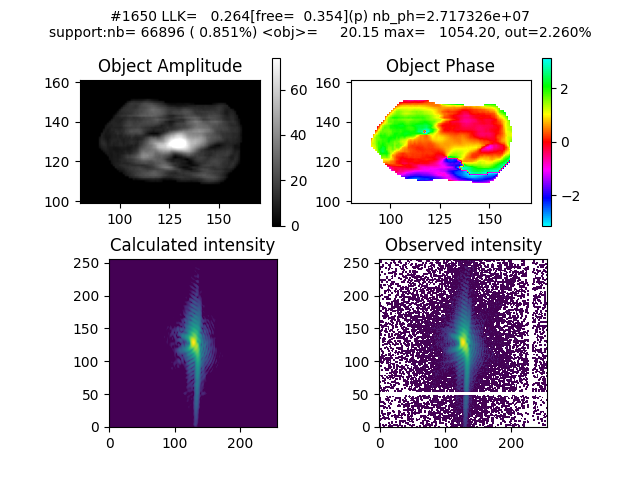

 HIO #  0 LLK=   6.718[free=  3.515](p), nb photons=1.171477e+07, support:nb= 62465 ( 0.794%) <obj>=     13.69 max=   1021.41, out=34.067% dt/cycle=0.7171s 
 HIO # 50 LLK=   6.327[free=  1.086](p), nb photons=4.740305e+07, support:nb=278889 ( 3.546%) <obj>=     13.04 max=   1074.15, out=19.268% dt/cycle=0.0159s 
 HIO #100 LLK=   4.955[free=  0.579](p), nb photons=4.106525e+07, support:nb=1253027 (15.933%) <obj>=      5.72 max=   1357.15, out=7.536% dt/cycle=0.0177s 
 HIO #150 LLK=   3.742[free=  0.505](p), nb photons=3.342834e+07, support:nb=3666356 (46.620%) <obj>=      3.02 max=   1738.49, out=3.250% dt/cycle=0.0166s 
 HIO #200 LLK= 46435020000000000.000[free=  0.610](p), nb photons=3.099728e+07, support:nb=7824508 (99.494%) <obj>=      1.99 max=   2102.13, out=0.028% dt/cycle=0.0164s 
 HIO #250 LLK=   0.000[free=  0.627](p), nb photons=2.804716e+07, support:nb=3796864 (48.280%) <obj>=      2.72 max=   1859.35, out=1.110% dt/cycle=0.0163s 
 HIO #300 LLK= 34557610000000000.000[free=  

<IPython.core.display.Javascript object>


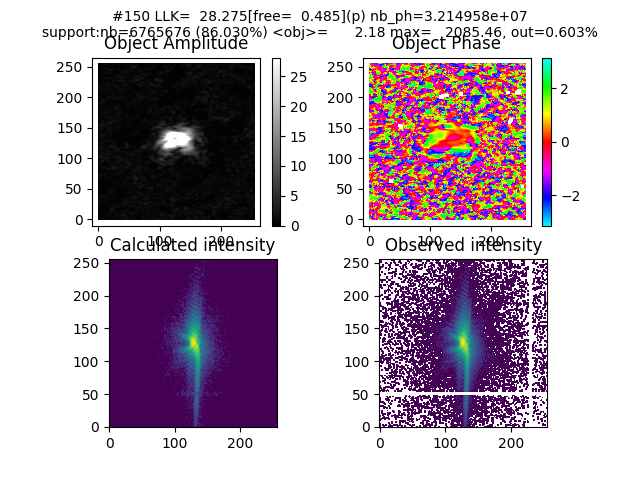

 HIO #  0 LLK=   6.629[free=  5.590](p), nb photons=1.154265e+07, support:nb= 63839 ( 0.812%) <obj>=     13.45 max=   1024.97, out=33.767% dt/cycle=0.6998s 
 HIO # 50 LLK=   6.534[free=  1.374](p), nb photons=4.899356e+07, support:nb=395295 ( 5.026%) <obj>=     11.13 max=   1118.99, out=16.915% dt/cycle=0.0180s 
 HIO #100 LLK=   4.876[free=  0.521](p), nb photons=3.933791e+07, support:nb=1888282 (24.011%) <obj>=      4.56 max=   1488.85, out=6.090% dt/cycle=0.0160s 
 HIO #150 LLK=  28.275[free=  0.485](p), nb photons=3.214958e+07, support:nb=6765676 (86.030%) <obj>=      2.18 max=   2085.46, out=0.603% dt/cycle=0.0162s 

##################################################################################################

Run 16
Threshold: 0.17886507410053717
AutoCorrelation: 62299 pixels in support (  0.79%), threshold = 2751895.500000


<IPython.core.display.Javascript object>


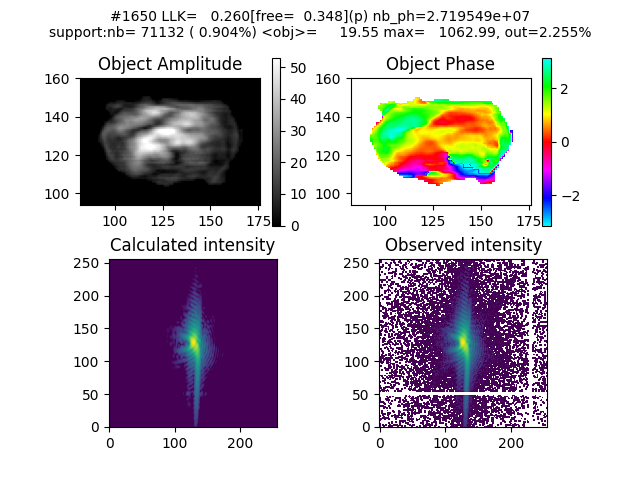

 HIO #  0 LLK=   6.713[free=  2.127](p), nb photons=1.173710e+07, support:nb= 62299 ( 0.792%) <obj>=     13.73 max=   1022.01, out=34.264% dt/cycle=0.6784s 
 HIO # 50 LLK=   6.694[free=  0.621](p), nb photons=4.859675e+07, support:nb=357600 ( 4.547%) <obj>=     11.66 max=   1108.06, out=19.832% dt/cycle=0.0180s 
 HIO #100 LLK=   4.980[free=  0.506](p), nb photons=4.022010e+07, support:nb=1583917 (20.141%) <obj>=      5.04 max=   1437.75, out=6.904% dt/cycle=0.0159s 
 HIO #150 LLK=   7.713[free=  0.438](p), nb photons=3.285740e+07, support:nb=5623925 (71.512%) <obj>=      2.42 max=   1986.27, out=1.441% dt/cycle=0.0166s 
 HIO #200 LLK= 21917265000000000.000[free=  0.874](p), nb photons=3.013931e+07, support:nb=7864229 (99.999%) <obj>=      1.96 max=   2194.41, out=0.000% dt/cycle=0.0165s 
 HIO #250 LLK=   0.000[free=  0.874](p), nb photons=2.829710e+07, support:nb=5338218 (67.879%) <obj>=      2.30 max=   2075.75, out=0.496% dt/cycle=0.0163s 
 HIO #300 LLK= 19216777500000000.000[free=  

<IPython.core.display.Javascript object>


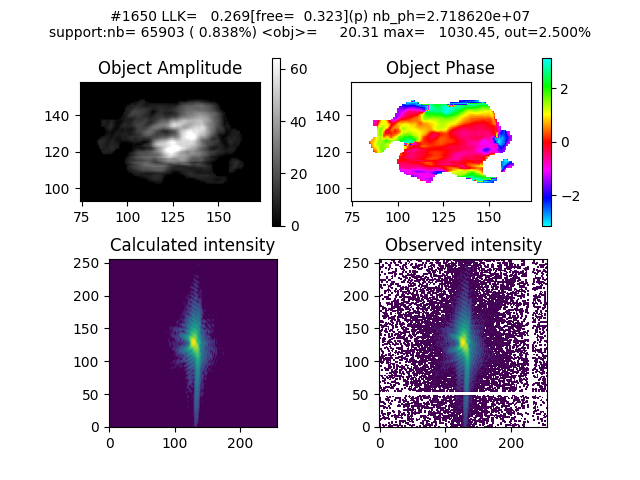

 HIO #  0 LLK=   6.655[free=  2.872](p), nb photons=1.173892e+07, support:nb= 62233 ( 0.791%) <obj>=     13.73 max=   1021.60, out=34.144% dt/cycle=0.6972s 
 HIO # 50 LLK=   7.528[free=  0.650](p), nb photons=5.185344e+07, support:nb=371173 ( 4.720%) <obj>=     11.82 max=   1079.29, out=22.244% dt/cycle=0.0159s 
 HIO #100 LLK=   5.005[free=  0.427](p), nb photons=4.056070e+07, support:nb=1573840 (20.012%) <obj>=      5.08 max=   1422.99, out=6.710% dt/cycle=0.0180s 
 HIO #150 LLK=   5.611[free=  0.389](p), nb photons=3.274984e+07, support:nb=5114759 (65.038%) <obj>=      2.53 max=   1906.59, out=1.801% dt/cycle=0.0161s 
 HIO #200 LLK= 26858945000000000.000[free=  0.720](p), nb photons=3.035739e+07, support:nb=7863596 (99.991%) <obj>=      1.96 max=   2149.08, out=0.000% dt/cycle=0.0164s 
 HIO #250 LLK=   0.000[free=  0.720](p), nb photons=2.821449e+07, support:nb=4892988 (62.218%) <obj>=      2.40 max=   1999.45, out=0.620% dt/cycle=0.0162s 
 HIO #300 LLK= 21988140000000000.000[free=  

<IPython.core.display.Javascript object>


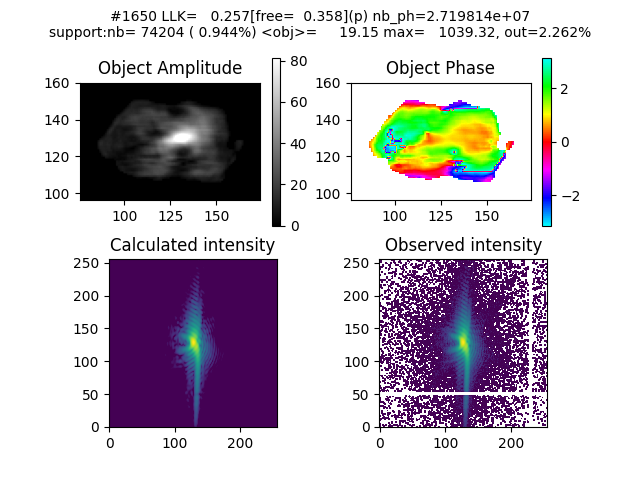

 HIO #  0 LLK=   6.645[free=  4.805](p), nb photons=1.166600e+07, support:nb= 62923 ( 0.800%) <obj>=     13.62 max=   1021.77, out=33.958% dt/cycle=0.6990s 
 HIO # 50 LLK=   6.645[free=  0.869](p), nb photons=4.809618e+07, support:nb=363107 ( 4.617%) <obj>=     11.51 max=   1099.10, out=19.867% dt/cycle=0.0159s 
 HIO #100 LLK=   5.017[free=  0.579](p), nb photons=4.046936e+07, support:nb=1673410 (21.279%) <obj>=      4.92 max=   1444.20, out=6.432% dt/cycle=0.0155s 
 HIO #150 LLK=   6.736[free=  0.496](p), nb photons=3.253484e+07, support:nb=5523550 (70.236%) <obj>=      2.43 max=   1938.55, out=1.436% dt/cycle=0.0160s 
 HIO #200 LLK= 22375572500000000.000[free=  0.916](p), nb photons=3.016793e+07, support:nb=7864031 (99.996%) <obj>=      1.96 max=   2160.41, out=0.000% dt/cycle=0.0186s 
 HIO #250 LLK=   0.000[free=  0.916](p), nb photons=2.830979e+07, support:nb=5246978 (66.719%) <obj>=      2.32 max=   2034.36, out=0.518% dt/cycle=0.0162s 
 HIO #300 LLK= 19342697500000000.000[free=  

<IPython.core.display.Javascript object>


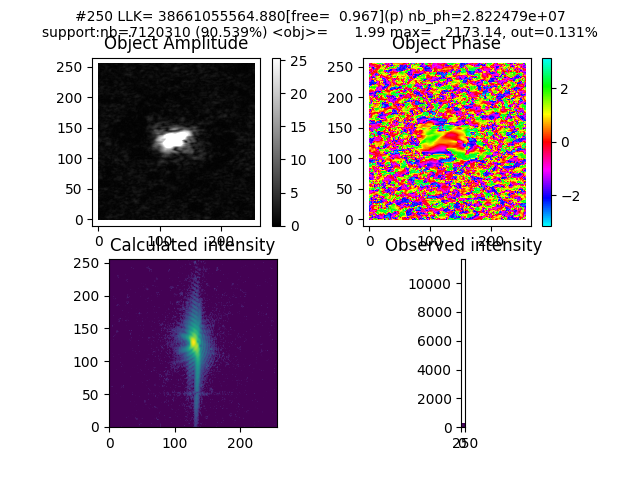

 HIO #  0 LLK=   6.679[free=  3.696](p), nb photons=1.171405e+07, support:nb= 62513 ( 0.795%) <obj>=     13.69 max=   1022.38, out=34.004% dt/cycle=0.7022s 
 HIO # 50 LLK=   7.214[free=  0.824](p), nb photons=4.918328e+07, support:nb=460384 ( 5.854%) <obj>=     10.34 max=   1127.67, out=23.205% dt/cycle=0.0158s 
 HIO #100 LLK=   5.002[free=  0.463](p), nb photons=3.896858e+07, support:nb=2190604 (27.855%) <obj>=      4.22 max=   1519.89, out=5.510% dt/cycle=0.0184s 
 HIO #150 LLK= 85005040000000000.000[free=  0.485](p), nb photons=3.171583e+07, support:nb=7371778 (93.737%) <obj>=      2.07 max=   2115.39, out=0.244% dt/cycle=0.0162s 
 HIO #200 LLK= 1416562812500000.000[free=  0.967](p), nb photons=2.836016e+07, support:nb=7863496 (99.990%) <obj>=      1.90 max=   2199.37, out=0.000% dt/cycle=0.0165s 
 HIO #250 LLK= 38661055564.880[free=  0.967](p), nb photons=2.822479e+07, support:nb=7120310 (90.539%) <obj>=      1.99 max=   2173.14, out=0.131% dt/cycle=0.0165s 

######################

In [6]:
nrun = 20

for i in range(nrun):
    print(f"Run {i}")
    # Create cdi object with data and mask, laod the main parameters
    cdi = CDI(fftshift(iobs),
              support = None,
              obj = None,
              mask = fftshift(mask),
              wavelength = wavelength,
              pixel_size_detector = pixel_size_detector,
             detector_distance = detector_distance)

    # Change support threshold for supports update
    threshold_relative = np.random.uniform(0.15, 0.20, 1)[0]
    print(f"Threshold: {threshold_relative}")
    
    sup = SupportUpdate(
        threshold_relative = threshold_relative,
        smooth_width=(2, 1, 600),
        force_shrink = False,
        method='rms', 
        post_expand = (1, -2, 1),
    )
    
    # Initialize the free pixels for LLK
    cdi = InitFreePixels() * cdi

    # Initialize the support with autocorrelation
    cdi = ShowCDI() * ScaleObj() * AutoCorrelationSupport(
        threshold = 0.1,
        verbose = True) * cdi

    # Begin with HIO cycles without PSF and with support updates
    try:
        cdi = (sup * HIO(beta=0.9, calc_llk=50, show_cdi=50)**50)**8 * cdi
        cdi = (sup * RAAR(beta=0.9, calc_llk=50, show_cdi=50)**50)**10 * cdi

        # PSF is introduced at 66% of HIO and RAAR so from cycle n°924
        cdi = InitPSF(
            model = "gaussian",
            fwhm = 0.5,
            # eta = 0.1,
        ) * cdi

        cdi = RAAR(beta=0.9, calc_llk=50, show_cdi=50, update_psf=50)**500 * cdi
        cdi = (sup * ER(calc_llk=50, show_cdi=50, update_psf=0)**50)**6 * cdi

        cdi.save_obj_cxi(f"result_run{i}_no_sup_psf.cxi")
    except SupportTooLarge:
        pass
        
    
    print("\n##################################################################################################\n")

# Create support

In [48]:
import h5py
import glob
from scipy.ndimage import gaussian_filter

%matplotlib inline

In [49]:
good_scan = "result_run1_no_sup_psf.cxi"

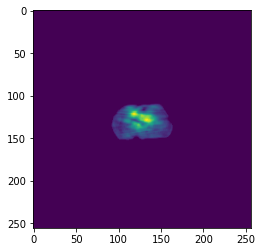

In [51]:
# Get data

with h5py.File(good_scan, "r") as f:
    data = f["entry_1"]["data_1"]["data"][:]

plt.imshow(np.abs(data[data.shape[0]//2, :, :][:]))

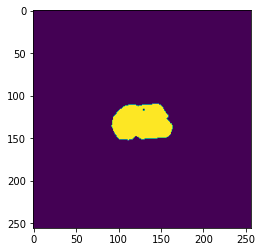

In [52]:
# Create support 

amp = np.abs(data)
threshold = 0.05
support = np.where(amp > threshold * np.max(amp), 1, 0)

plt.imshow(support[data.shape[0]//2, :, :][:])

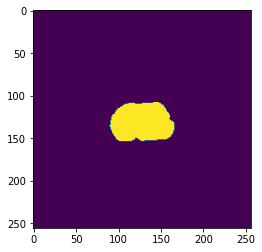

In [56]:
sigma = 0.8

bigdata = 100 * support
conv_support = np.where(gaussian_filter(bigdata, sigma) != 0, 1, 0)

plt.imshow(conv_mask[data.shape[0]//2, :, :][:])

np.savez(f"support_filter_sig_{sigma}_threshold_{threshold}.npz", oldmask = support, mask = conv_support)

# Get support

In [59]:
support = np.load(f"support_filter_sig_{sigma}_threshold_{threshold}.npz")["mask"].astype("int8")

# Run 2

Run 0
Threshold: 0.2541185931440173


<IPython.core.display.Javascript object>


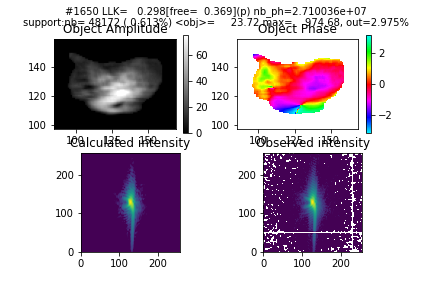

 HIO #  0 LLK=     inf[free=    inf](p), nb photons=6.626198e+04, support:nb= 78748 ( 1.001%) <obj>=      0.92 max=     84.95, out=99.003% dt/cycle=0.6318s 
 HIO # 50 LLK=   4.545[free=  0.545](p), nb photons=4.150414e+07, support:nb=133845 ( 1.702%) <obj>=     17.61 max=   1077.31, out=9.103% dt/cycle=0.0150s 
 HIO #100 LLK=   5.494[free=  0.504](p), nb photons=4.457922e+07, support:nb=367901 ( 4.678%) <obj>=     11.01 max=   1133.75, out=8.780% dt/cycle=0.0017s 
 HIO #150 LLK=   4.304[free=  0.513](p), nb photons=4.069658e+07, support:nb=586122 ( 7.453%) <obj>=      8.33 max=   1193.84, out=7.786% dt/cycle=0.0147s 
 HIO #200 LLK=   4.651[free=  0.461](p), nb photons=4.013558e+07, support:nb=1185451 (15.074%) <obj>=      5.82 max=   1368.00, out=6.564% dt/cycle=0.0017s 
 HIO #250 LLK=   2.606[free=  0.436](p), nb photons=3.435172e+07, support:nb=1392955 (17.712%) <obj>=      4.97 max=   1411.70, out=5.574% dt/cycle=0.0166s 
 HIO #300 LLK=   2.408[free=  0.429](p), nb photons=3.433366e

<IPython.core.display.Javascript object>


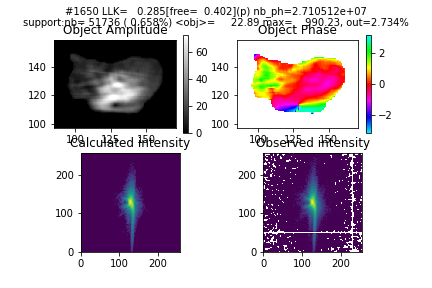

 HIO #  0 LLK=     inf[free=    inf](p), nb photons=6.626198e+04, support:nb= 78748 ( 1.001%) <obj>=      0.92 max=     84.95, out=99.003% dt/cycle=0.6555s 
 HIO # 50 LLK=   4.492[free=  0.650](p), nb photons=4.146837e+07, support:nb=142299 ( 1.809%) <obj>=     17.07 max=   1061.44, out=8.468% dt/cycle=0.0151s 
 HIO #100 LLK=   5.728[free=  0.772](p), nb photons=4.502834e+07, support:nb=478492 ( 6.084%) <obj>=      9.70 max=   1149.32, out=8.604% dt/cycle=0.0017s 
 HIO #150 LLK=   3.676[free=  0.523](p), nb photons=3.839760e+07, support:nb=707314 ( 8.994%) <obj>=      7.37 max=   1233.20, out=7.575% dt/cycle=0.0167s 
 HIO #200 LLK=   4.133[free=  0.466](p), nb photons=3.812878e+07, support:nb=1496143 (19.024%) <obj>=      5.05 max=   1451.10, out=5.456% dt/cycle=0.0017s 
 HIO #250 LLK=   2.299[free=  0.463](p), nb photons=3.309272e+07, support:nb=1917958 (24.388%) <obj>=      4.15 max=   1513.85, out=4.281% dt/cycle=0.0148s 
 HIO #300 LLK=   1.800[free=  0.459](p), nb photons=3.234386e

<IPython.core.display.Javascript object>


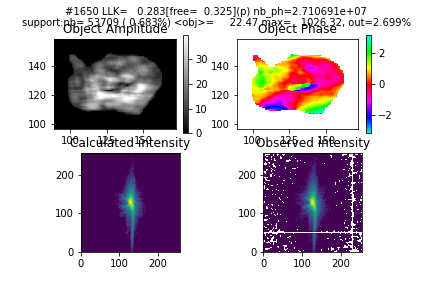

 HIO #  0 LLK=     inf[free=    inf](p), nb photons=6.626198e+04, support:nb= 78748 ( 1.001%) <obj>=      0.92 max=     84.95, out=99.003% dt/cycle=0.6574s 
 HIO # 50 LLK=   4.369[free=  0.538](p), nb photons=4.095809e+07, support:nb=132487 ( 1.685%) <obj>=     17.58 max=   1084.05, out=8.362% dt/cycle=0.0172s 
 HIO #100 LLK=   5.464[free=  0.480](p), nb photons=4.456544e+07, support:nb=377585 ( 4.801%) <obj>=     10.86 max=   1121.59, out=8.152% dt/cycle=0.0017s 
 HIO #150 LLK=   4.131[free=  0.497](p), nb photons=4.037932e+07, support:nb=609168 ( 7.746%) <obj>=      8.14 max=   1200.06, out=7.375% dt/cycle=0.0147s 
 HIO #200 LLK=   4.413[free=  0.393](p), nb photons=3.965075e+07, support:nb=1162597 (14.783%) <obj>=      5.84 max=   1346.08, out=6.194% dt/cycle=0.0017s 
 HIO #250 LLK=   2.685[free=  0.415](p), nb photons=3.448741e+07, support:nb=1464782 (18.626%) <obj>=      4.85 max=   1441.92, out=5.428% dt/cycle=0.0147s 
 HIO #300 LLK=   2.188[free=  0.381](p), nb photons=3.383620e

<IPython.core.display.Javascript object>


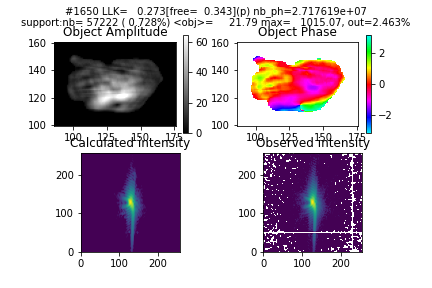

 HIO #  0 LLK=     inf[free=    inf](p), nb photons=6.626198e+04, support:nb= 78748 ( 1.001%) <obj>=      0.92 max=     84.95, out=99.003% dt/cycle=0.6583s 
 HIO # 50 LLK=   4.383[free=  0.565](p), nb photons=4.105102e+07, support:nb=182268 ( 2.318%) <obj>=     15.01 max=   1093.57, out=8.413% dt/cycle=0.0151s 
 HIO #100 LLK=   5.434[free=  0.547](p), nb photons=4.328722e+07, support:nb=711679 ( 9.049%) <obj>=      7.80 max=   1229.05, out=7.698% dt/cycle=0.0017s 
 HIO #150 LLK=   3.240[free=  0.482](p), nb photons=3.618978e+07, support:nb=1242955 (15.805%) <obj>=      5.40 max=   1350.82, out=6.193% dt/cycle=0.0148s 
 HIO #200 LLK=   3.521[free=  0.477](p), nb photons=3.514381e+07, support:nb=2470006 (31.408%) <obj>=      3.77 max=   1620.86, out=3.736% dt/cycle=0.0017s 
 HIO #250 LLK=   2.094[free=  0.525](p), nb photons=3.122840e+07, support:nb=3852898 (48.992%) <obj>=      2.85 max=   1825.89, out=1.894% dt/cycle=0.0147s 
 HIO #300 LLK=   2.463[free=  0.626](p), nb photons=3.022711

In [ ]:
%matplotlib notebook

nrun = 20

for i in range(nrun):
    print(f"Run {i}")
    # Create cdi object with data and mask, laod the main parameters
    cdi = CDI(fftshift(iobs),
      support = fftshift(support),
              obj = None,
              mask = fftshift(mask),
              wavelength = wavelength,
              pixel_size_detector = pixel_size_detector,
             detector_distance = detector_distance)

    # Change support threshold for supports update
    threshold_relative = np.random.uniform(0.20, 0.26, 1)[0]
    print(f"Threshold: {threshold_relative}")
    
    sup = SupportUpdate(
        threshold_relative = threshold_relative,
        # threshold_relative = 0.28,
        smooth_width=(2, 1, 600),
        force_shrink = False,
        method='rms', 
        post_expand = (1, -2, 1),
    )
    
    # Initialize the free pixels for LLK
    cdi = InitFreePixels() * cdi

    # Initialize the support with autocorrelation
    cdi = ShowCDI() * ScaleObj() * cdi

    # Begin with HIO cycles without PSF and with support updates
    try:
        cdi = (sup * HIO(beta=0.7, calc_llk=50, show_cdi=100)**50)**8 * cdi
        cdi = (sup * RAAR(beta=0.9, calc_llk=50, show_cdi=100)**50)**10 * cdi

        # PSF is introduced at 66% of HIO and RAAR so from cycle n°924
        cdi = InitPSF(
            model = "gaussian",
            fwhm = 0.5,
            # eta = 0.05,
        ) * cdi

        # cdi = RAAR(beta=0.9, calc_llk=50, show_cdi=50, update_psf=50)**500 * cdi
        # cdi = ER(calc_llk=50, show_cdi=50, update_psf=0)**300 * cdi
        cdi = (sup * RAAR(beta=0.9, calc_llk=50, show_cdi=50, update_psf=50)**50)**10 * cdi
        cdi = (sup * ER(calc_llk=50, show_cdi=50, update_psf=50)**50)**6 * cdi

        cdi.save_obj_cxi(f"result_run{i}_no_sup_psf.cxi")
    except SupportTooLarge:
        pass
        
    
    print("\n##################################################################################################\n")